In [ ]:
#解压代码压缩包
import zipfile
tar = zipfile.ZipFile('/home/aistudio/data/data19725/attack_by_xin.zip','r')
tar.extractall()

In [ ]:
#coding=utf-8

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import functools
import numpy as np
import paddle.fluid as fluid

#加载自定义文件
import models
##################################################
##################################################
#此处为导入算法FGSM和PGD
#我方案中函数也将定义在attack/attack_pp.py中
from attack.attack_pp import FGSM, PGD
##################################################
##################################################
from utils import init_prog, save_adv_image, process_img, tensor2img, calc_mse, add_arguments, print_arguments

path = "/home/aistudio/baidu_attack_by_xin/"
######Init args
image_shape = [3,224,224]
class_dim=121
input_dir = path + "input_image/"
output_dir = path +  "output_image/"
model_name="ResNeXt50_32x4d"
pretrained_model= path + "models_parameters/86.45+88.81ResNeXt50_32x4d"

val_list = 'val_list.txt'
use_gpu=True

######Attack graph
adv_program=fluid.Program()
#完成初始化
with fluid.program_guard(adv_program):
    input_layer = fluid.layers.data(name='image', shape=image_shape, dtype='float32')
    #设置为可以计算梯度
    input_layer.stop_gradient=False

    # model definition
    model = models.__dict__[model_name]()
    out_logits = model.net(input=input_layer, class_dim=class_dim)
    out = fluid.layers.softmax(out_logits)

    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
    exe = fluid.Executor(place)
    exe.run(fluid.default_startup_program())

    #记载模型参数
    fluid.io.load_persistables(exe, pretrained_model)

#设置adv_program的BN层状态
init_prog(adv_program)

#创建测试用评估模式
eval_program = adv_program.clone(for_test=True)

#定义梯度
with fluid.program_guard(adv_program):
    label = fluid.layers.data(name="label", shape=[1] ,dtype='int64')
    loss = fluid.layers.cross_entropy(input=out, label=label)
    gradients = fluid.backward.gradients(targets=loss, inputs=[input_layer])[0]

######Inference
def inference(img):
    fetch_list = [out.name]

    result = exe.run(eval_program,
                     fetch_list=fetch_list,
                     feed={ 'image':img })
    result = result[0][0]
    pred_label = np.argmax(result)
    pred_score = result[pred_label].copy()
    return pred_label, pred_score

######FGSM attack
#untarget attack
def attack_nontarget_by_FGSM(img, src_label):
    pred_label = src_label

    step = 8.0/256.0
    eps = 32.0/256.0
    while pred_label == src_label:
        #生成对抗样本
        adv=FGSM(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
                 input_layer=input_layer,output_layer=out,step_size=step,epsilon=eps,
                 isTarget=False,target_label=0,use_gpu=use_gpu)

        pred_label, pred_score = inference(adv)
        step *= 2
        if step > eps:
            break

    print("Test-score: {0}, class {1}".format(pred_score, pred_label))

    adv_img=tensor2img(adv)
    return adv_img

####### Main #######
def get_original_file(filepath):
    with open(filepath, 'r') as cfile:
        full_lines = [line.strip() for line in cfile]
    cfile.close()
    original_files = []
    for line in full_lines:
        label, file_name = line.split()
        original_files.append([file_name, int(label)])
    return original_files

def gen_adv():
    ########如果你没有头绪可以从这部分看起#######################
    mse = 0
    original_files = get_original_file(input_dir + val_list)

    for filename, label in original_files:
        img_path = input_dir + filename
        print("Image: {0} ".format(img_path))
        ##读入图像，转换维度，归一化##########
        img=process_img(img_path)
        ####将图像输入attack_nontarget_by_FGSM函数，得到被攻击后的图像#######
        adv_img = attack_nontarget_by_FGSM(img, label)
        image_name, image_ext = filename.split('.')
        ##Save adversarial image(.png) 保存图像
        save_adv_image(adv_img, output_dir+image_name+'.jpg')

        org_img = tensor2img(img)
        ##对比攻击图像与原图像的差异，计算mse
        score = calc_mse(org_img, adv_img)
        mse += score
    print("ADV {} files, AVG MSE: {} ".format(len(original_files), mse/len(original_files)))


gen_adv()


Image: /home/aistudio/baidu_attack_by_xin/input_image/n02085620_10074.jpg 
Non-Targeted attack target_label=o_label=1
Non-Targeted attack target_label=o_label=1
Non-Targeted attack target_label=o_label=1
Test-score: 0.1829851120710373, class 1
Image: /home/aistudio/baidu_attack_by_xin/input_image/n02085782_1039.jpg 
Non-Targeted attack target_label=o_label=2
Non-Targeted attack target_label=o_label=2
Non-Targeted attack target_label=o_label=2
Test-score: 0.7980572581291199, class 2
Image: /home/aistudio/baidu_attack_by_xin/input_image/n02085936_10130.jpg 
Non-Targeted attack target_label=o_label=3
Test-score: 0.558245837688446, class 54
Image: /home/aistudio/baidu_attack_by_xin/input_image/n02086079_10600.jpg 
Non-Targeted attack target_label=o_label=4
Test-score: 0.4213048815727234, class 5
Image: /home/aistudio/baidu_attack_by_xin/input_image/n02086240_1059.jpg 
Non-Targeted attack target_label=o_label=5
Non-Targeted attack target_label=o_label=5
Non-Targeted attack target_label=o_la

In [ ]:
def FGSM(adv_program,eval_program,gradients,o,input_layer,output_layer,step_size=16.0/256,epsilon=16.0/256,isTarget=False,target_label=0,use_gpu=False):
    
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
    exe = fluid.Executor(place)
   
    result = exe.run(eval_program,
                     fetch_list=[output_layer],
                     feed={ input_layer.name:o })
    result = result[0][0]
   
    o_label = np.argsort(result)[::-1][:1][0]
    
    if not isTarget:
        #无定向攻击 target_label的值自动设置为原标签的值
        print("Non-Targeted attack target_label=o_label={}".format(o_label))
        target_label=o_label
    else:
        print("Targeted attack target_label={} o_label={}".format(target_label,o_label))
        
        
    target_label=np.array([target_label]).astype('int64')
    target_label=np.expand_dims(target_label, axis=0)
    
    #计算梯度
    g = exe.run(adv_program,
                     fetch_list=[gradients],
                     feed={ input_layer.name:o,'label': target_label  }
               )
    g = g[0][0]
    
    
    if isTarget:
        adv=o-np.sign(g)*step_size
    else:
        #################################
        #注意此处符号
        adv=o+np.sign(g)*step_size
    
    #实施linf约束
    adv=linf_img_tenosr(o,adv,epsilon)
    
    return adv

### 1.3 让我们看看生成的对抗样本和原来有什么区别

In [ ]:
#定义一个观察图片区别的函数
def show_images_diff(original_img,adversarial_img):
    #original_img = np.array(Image.open(original_img))
    #adversarial_img = np.array(Image.open(adversarial_img))
    original_img=cv2.resize(original_img.copy(),(224,224))
    adversarial_img=cv2.resize(adversarial_img.copy(),(224,224))

    plt.figure(figsize=(10,10))

    #original_img=original_img/255.0
    #adversarial_img=adversarial_img/255.0

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial Image')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = 0.0+adversarial_img - original_img
        
    l0 = np.where(difference != 0)[0].shape[0]*100/(224*224*3)
    l2 = np.linalg.norm(difference)/(256*3)
    linf=np.linalg.norm(difference.copy().ravel(),ord=np.inf)
    # print(difference)
    print("l0={}% l2={} linf={}".format(l0, l2,linf))
    
    #(-1,1)  -> (0,1)
    #灰色打底 容易看出区别
    difference=difference/255.0
        
    difference=difference/2.0+0.5
   
    plt.imshow(difference)
    plt.axis('off')

    plt.show()
    

    #plt.savefig('fig_cat.png')

l0=92.0014880952381% l2=3.203206511496744 linf=31.0


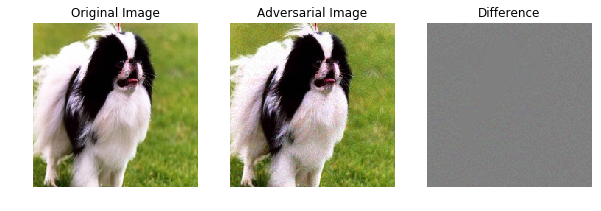

In [ ]:
from PIL import Image, ImageOps
import cv2
import matplotlib.pyplot as plt
original_img=np.array(Image.open("/home/aistudio/baidu_attack_by_xin/input_image/n02085782_1039.jpg"))
adversarial_img=np.array(Image.open("/home/aistudio/baidu_attack_by_xin/output_image/n02085782_1039.jpg"))
show_images_diff(original_img,adversarial_img)

In [ ]:
#coding=utf-8
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import sys
import os
import numpy as np
import paddle.fluid as fluid
import pandas as pd
import models
from attack.attack_pp import FGSM, PGD,linf_img_tenosr,ensem_mom_attack_threshold_9model,\
ensem_mom_attack_threshold_9model2,ensem_mom_attack_threshold_9model_tarversion
from utils import init_prog, save_adv_image, process_img, tensor2img, calc_mse, add_arguments, print_arguments

image_shape = [3, 224, 224]
class_dim=121
input_dir = "./input_image/"
output_dir = "./output_image_attack/"
os.makedirs("./output_image_attack") 
#######################################################################
#这就是所用的所有模型
model_name1="ResNeXt50_32x4d"
pretrained_model1="./models_parameters/86.45+88.81ResNeXt50_32x4d"

model_name2="MobileNetV2"
pretrained_model2="./models_parameters/MobileNetV2"

model_name4="VGG16"
pretrained_model4="./models_parameters/VGG16"

model_name3="Densenet121"
pretrained_model3="./models_parameters/Densenet121"

model_name5="mnasnet1_0"
pretrained_model5="./models_parameters/mnasnet1_0"

model_name6="wide_resnet"
pretrained_model6="./models_parameters/wide_resnet"

model_name7="googlenet"
pretrained_model7="./models_parameters/googlenet"

model_name8="nas_mobile_net"
pretrained_model8="./models_parameters/nas_mobile_net"

model_name9="alexnet"
pretrained_model9="./models_parameters/alexnet"
########################################################################
val_list = 'val_list.txt'
use_gpu=True

mydict = {0: 1, 1: 10, 2: 100, 3: 101, 4: 102, 5: 103, 6: 104, 7: 105, 8: 106, 9: 107, 10: 108, 11: 109, 12: 11, 13: 110, 14: 111, 15: 112, 16: 113, 17: 114, 18: 115, 19: 116, 20: 117, 21: 118, 22: 119, 23: 12, 24: 120, 25: 13, 26: 14, 27: 15, 28: 16, 29: 17, 30: 18, 31: 19, 32: 2, 33: 20, 34: 21, 35: 22, 36: 23, 37: 24, 38: 25, 39: 26, 40: 27, 41: 28, 42: 29, 43: 3, 44: 30, 45: 31, 46: 32, 47: 33, 48: 34, 49: 35, 50: 36, 51: 37, 52: 38, 53: 39, 54: 4, 55: 40, 56: 41, 57: 42, 58: 43, 59: 44, 60: 45, 61: 46, 62: 47, 63: 48, 64: 49, 65: 5, 66: 50, 67: 51, 68: 52, 69: 53, 70: 54, 71: 55, 72: 56, 73: 57, 74: 58, 75: 59, 76: 6, 77: 60, 78: 61, 79: 62, 80: 63, 81: 64, 82: 65, 83: 66, 84: 67, 85: 68, 86: 69, 87: 7, 88: 70, 89: 71, 90: 72, 91: 73, 92: 74, 93: 75, 94: 76, 95: 77, 96: 78, 97: 79, 98: 8, 99: 80, 100: 81, 101: 82, 102: 83, 103: 84, 104: 85, 105: 86, 106: 87, 107: 88, 108: 89, 109: 9, 110: 90, 111: 91, 112: 92, 113: 93, 114: 94, 115: 95, 116: 96, 117: 97, 118: 98, 119: 99}
origdict = {1: 0, 2: 32, 3: 43, 4: 54, 5: 65, 6: 76, 7: 87, 8: 98, 9: 109, 10: 1, 11: 12, 12: 23, 13: 25, 14: 26, 15: 27, 16: 28, 17: 29, 18: 30, 19: 31, 20: 33, 21: 34, 22: 35, 23: 36, 24: 37, 25: 38, 26: 39, 27: 40, 28: 41, 29: 42, 30: 44, 31: 45, 32: 46, 33: 47, 34: 48, 35: 49, 36: 50, 37: 51, 38: 52, 39: 53, 40: 55, 41: 56, 42: 57, 43: 58, 44: 59, 45: 60, 46: 61, 47: 62, 48: 63, 49: 64, 50: 66, 51: 67, 52: 68, 53: 69, 54: 70, 55: 71, 56: 72, 57: 73, 58: 74, 59: 75, 60: 77, 61: 78, 62: 79, 63: 80, 64: 81, 65: 82, 66: 83, 67: 84, 68: 85, 69: 86, 70: 88, 71: 89, 72: 90, 73: 91, 74: 92, 75: 93, 76: 94, 77: 95, 78: 96, 79: 97, 80: 99, 81: 100, 82: 101, 83: 102, 84: 103, 85: 104, 86: 105, 87: 106, 88: 107, 89: 108, 90: 110, 91: 111, 92: 112, 93: 113, 94: 114, 95: 115, 96: 116, 97: 117, 98: 118, 99: 119, 100: 2, 101: 3, 102: 4, 103: 5, 104: 6, 105: 7, 106: 8, 107: 9, 108: 10, 109: 11, 110: 13, 111: 14, 112: 15, 113: 16, 114: 17, 115: 18, 116: 19, 117: 20, 118: 21, 119: 22, 120: 24}

adv_program=fluid.Program()
startup_program = fluid.Program()

new_scope = fluid.Scope()
#完成初始化
with fluid.program_guard(adv_program):
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
    exe = fluid.Executor(place)
    label = fluid.layers.data(name="label", shape=[1] ,dtype='int64')
    label2 = fluid.layers.data(name="label2", shape=[1] ,dtype='int64')
    adv_image = fluid.layers.create_parameter(name="adv_image",shape=(1,3,224,224),dtype='float32')
    
    model1 = models.__dict__[model_name1]()
    out_logits1 = model1.net(input=adv_image, class_dim=class_dim)
    out1 = fluid.layers.softmax(out_logits1)

    model2 = models.__dict__[model_name2](scale=2.0)
    out_logits2 = model2.net(input=adv_image, class_dim=class_dim)
    out2 = fluid.layers.softmax(out_logits2)

    _input1 = fluid.layers.create_parameter(name="_input_1", shape=(1,3,224,224),dtype='float32')
    
    model3 = models.__dict__[model_name3]()
    input_layer3,out_logits3 = model3.x2paddle_net(input =adv_image )
    out3 = fluid.layers.softmax(out_logits3[0])
    
    model4 = models.__dict__[model_name4]()
    input_layer4,out_logits4 = model4.x2paddle_net(input =adv_image )
    out4 = fluid.layers.softmax(out_logits4[0])


    model5 = models.__dict__[model_name5]()
    input_layer5,out_logits5 = model5.x2paddle_net(input =adv_image )
    out5 = fluid.layers.softmax(out_logits5[0])

    model6 = models.__dict__[model_name6]()
    input_layer6,out_logits6 = model6.x2paddle_net(input =adv_image)
    out6 = fluid.layers.softmax(out_logits6[0])

    model7 = models.__dict__[model_name7]()
    input_layer7,out_logits7 = model7.x2paddle_net(input =adv_image)
    out7 = fluid.layers.softmax(out_logits7[0])

    model8 = models.__dict__[model_name8]()
    input_layer8,out_logits8 = model8.x2paddle_net(input =adv_image)
    out8 = fluid.layers.softmax(out_logits8[0])
    
    
    model9 = models.__dict__[model_name9]()
    input_layer9,out_logits9 = model9.x2paddle_net(input =adv_image)
    out9 = fluid.layers.softmax(out_logits9[0])

    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
    exe = fluid.Executor(place)
    exe.run(fluid.default_startup_program())

    one_hot_label = fluid.one_hot(input=label, depth=121)
    one_hot_label2 = fluid.one_hot(input=label2, depth=121)
    smooth_label = fluid.layers.label_smooth(label=one_hot_label, epsilon=0.1, dtype="float32")[0]
    smooth_label2 = fluid.layers.label_smooth(label=one_hot_label2, epsilon=0.1, dtype="float32")[0]



    ze = fluid.layers.fill_constant(shape=[1], value=-1, dtype='float32')
    loss = 1.2*fluid.layers.matmul(ze, fluid.layers.cross_entropy(input=out1, label=label[0]))\
    + 0.2*fluid.layers.matmul(ze, fluid.layers.cross_entropy(input=out2, label=label[0]))\
    + fluid.layers.matmul(ze, fluid.layers.cross_entropy(input=out3, label=label2[0]))\
    + fluid.layers.matmul(ze, fluid.layers.cross_entropy(input=out4, label=label2[0]))\
    + fluid.layers.matmul(ze, fluid.layers.cross_entropy(input=out5, label=label2[0]))\
    + fluid.layers.matmul(ze, fluid.layers.cross_entropy(input=out6, label=label2[0]))\
    + fluid.layers.matmul(ze, fluid.layers.cross_entropy(input=out7, label=label2[0]))\
    + fluid.layers.matmul(ze, fluid.layers.cross_entropy(input=out8, label=label2[0]))\
    + fluid.layers.matmul(ze, fluid.layers.cross_entropy(input=out9, label=label2[0]))
    
    avg_loss=fluid.layers.reshape(loss ,[1])#这里修改loss

init_prog(adv_program)
eval_program = adv_program.clone(for_test=True)

with fluid.program_guard(adv_program): 
    #没有解决变量重名的问题
    #此部分代码为加载模型参数
    def if_exist(var):
        b = os.path.exists(os.path.join(pretrained_model1, var.name))
        return b
    def if_exist2(var):
        b = os.path.exists(os.path.join(pretrained_model2, var.name))
        return b
    def if_exist3(var):
        b = os.path.exists(os.path.join(pretrained_model3, var.name))
        return b
    def if_exist4(var):
        b = os.path.exists(os.path.join(pretrained_model4, var.name))
        return b
    def if_exist5(var):
        b = os.path.exists(os.path.join(pretrained_model5, var.name))
        return b
    def if_exist6(var):
        b = os.path.exists(os.path.join(pretrained_model6, var.name))
        return b
    def if_exist7(var):
        b = os.path.exists(os.path.join(pretrained_model7, var.name))
        return b
    def if_exist8(var):
        b = os.path.exists(os.path.join(pretrained_model8, var.name))
        return b
    def if_exist9(var):
        b = os.path.exists(os.path.join(pretrained_model9, var.name))
        return b
    fluid.io.load_vars(exe,
                       pretrained_model1,
                       fluid.default_main_program(),
                       predicate=if_exist)
    fluid.io.load_vars(exe,
                       pretrained_model2,
                       fluid.default_main_program(),
                       predicate=if_exist2)
    fluid.io.load_vars(exe,
                       pretrained_model3,
                       fluid.default_main_program(),
                       predicate=if_exist3)
    fluid.io.load_vars(exe,
                       pretrained_model4,
                       fluid.default_main_program(),
                       predicate=if_exist4)
    fluid.io.load_vars(exe,
                       pretrained_model5,
                       fluid.default_main_program(),
                       predicate=if_exist5)
    fluid.io.load_vars(exe,
                       pretrained_model6,
                       fluid.default_main_program(),
                       predicate=if_exist6)
    fluid.io.load_vars(exe,
                       pretrained_model7,
                       fluid.default_main_program(),
                       predicate=if_exist7)
    fluid.io.load_vars(exe,
                       pretrained_model8,
                       fluid.default_main_program(),
                       predicate=if_exist8)

    fluid.io.load_vars(exe,
                       pretrained_model9,
                       fluid.default_main_program(),
                       predicate=if_exist9)
    gradients = fluid.backward.gradients(targets=avg_loss, inputs=[adv_image])[0]
    #gradients = fluid.backward.gradients(targets=avg_loss, inputs=[adv_image])
    #print(gradients.shape)
    
def attack_nontarget_by_ensemble(img, src_label,src_label2,label,momentum): #src_label2为转换后的标签
    adv,m=ensem_mom_attack_threshold_9model_tarversion(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
                src_label = src_label,
                src_label2 = src_label2,
                label = label,
                out1 = out1,out2 = out2 ,out3 = out3 ,out4 = out4,out5 = out5,out6 = out6,out7 = out7 ,out8 = out8,out9 = out9,mm = momentum)#添加了mm

    adv_img=tensor2img(adv)
    return adv_img,m

def get_original_file(filepath):
    with open(filepath, 'r') as cfile:
        full_lines = [line.strip() for line in cfile]
    cfile.close()
    original_files = []
    for line in full_lines:
        label, file_name = line.split()
        original_files.append([file_name, int(label)])
    return original_files
    
def gen_adv():
    mse = 0
    original_files = get_original_file(input_dir + val_list)
    #下一个图片的初始梯度方向为上一代的最后的值
    global momentum
    momentum=0
    
    for filename, label in original_files:
        img_path = input_dir + filename
        print("Image: {0} ".format(img_path))
        img=process_img(img_path)
        #adv_img = attack_nontarget_by_ensemble(img, label,origdict[label],label)
        adv_img,m = attack_nontarget_by_ensemble(img, label,origdict[label],label,momentum)
        #m为上一个样本最后一次梯度值
        momentum = m
        #adv_img 已经经过转换了，范围是0-255

        image_name, image_ext = filename.split('.')
        ##Save adversarial image(.png)
        save_adv_image(adv_img, output_dir+image_name+'.png')
        org_img = tensor2img(img)
        score = calc_mse(org_img, adv_img)
        print("Image:{0}, mase = {1} ".format(img_path,score))
        mse += score
    print("ADV {} files, AVG MSE: {} ".format(len(original_files), mse/len(original_files)))

In [ ]:
def ensem_mom_attack_threshold_9model_tarversion(adv_program,eval_program,gradients,o,src_label2,src_label,out1,out2,out3,out4,out5,out6,out7,out8,out9,label,mm,iteration=20,use_gpu = True):
    origdict = {1: 0, 2: 32, 3: 43, 4: 54, 5: 65, 6: 76, 7: 87, 8: 98, 9: 109, 10: 1, 11: 12, 12: 23, 13: 25, 14: 26, 15: 27, 16: 28, 17: 29, 18: 30, 19: 31, 20: 33, 21: 34, 22: 35, 23: 36, 24: 37, 25: 38, 26: 39, 27: 40, 28: 41, 29: 42, 30: 44, 31: 45, 32: 46, 33: 47, 34: 48, 35: 49, 36: 50, 37: 51, 38: 52, 39: 53, 40: 55, 41: 56, 42: 57, 43: 58, 44: 59, 45: 60, 46: 61, 47: 62, 48: 63, 49: 64, 50: 66, 51: 67, 52: 68, 53: 69, 54: 70, 55: 71, 56: 72, 57: 73, 58: 74, 59: 75, 60: 77, 61: 78, 62: 79, 63: 80, 64: 81, 65: 82, 66: 83, 67: 84, 68: 85, 69: 86, 70: 88, 71: 89, 72: 90, 73: 91, 74: 92, 75: 93, 76: 94, 77: 95, 78: 96, 79: 97, 80: 99, 81: 100, 82: 101, 83: 102, 84: 103, 85: 104, 86: 105, 87: 106, 88: 107, 89: 108, 90: 110, 91: 111, 92: 112, 93: 113, 94: 114, 95: 115, 96: 116, 97: 117, 98: 118, 99: 119, 100: 2, 101: 3, 102: 4, 103: 5, 104: 6, 105: 7, 106: 8, 107: 9, 108: 10, 109: 11, 110: 13, 111: 14, 112: 15, 113: 16, 114: 17, 115: 18, 116: 19, 117: 20, 118: 21, 119: 22, 120: 24}
    mydict = {0: 1, 1: 10, 2: 100, 3: 101, 4: 102, 5: 103, 6: 104, 7: 105, 8: 106, 9: 107, 10: 108, 11: 109, 12: 11, 13: 110, 14: 111, 15: 112, 16: 113, 17: 114, 18: 115, 19: 116, 20: 117, 21: 118, 22: 119, 23: 12, 24: 120, 25: 13, 26: 14, 27: 15, 28: 16, 29: 17, 30: 18, 31: 19, 32: 2, 33: 20, 34: 21, 35: 22, 36: 23, 37: 24, 38: 25, 39: 26, 40: 27, 41: 28, 42: 29, 43: 3, 44: 30, 45: 31, 46: 32, 47: 33, 48: 34, 49: 35, 50: 36, 51: 37, 52: 38, 53: 39, 54: 4, 55: 40, 56: 41, 57: 42, 58: 43, 59: 44, 60: 45, 61: 46, 62: 47, 63: 48, 64: 49, 65: 5, 66: 50, 67: 51, 68: 52, 69: 53, 70: 54, 71: 55, 72: 56, 73: 57, 74: 58, 75: 59, 76: 6, 77: 60, 78: 61, 79: 62, 80: 63, 81: 64, 82: 65, 83: 66, 84: 67, 85: 68, 86: 69, 87: 7, 88: 70, 89: 71, 90: 72, 91: 73, 92: 74, 93: 75, 94: 76, 95: 77, 96: 78, 97: 79, 98: 8, 99: 80, 100: 81, 101: 82, 102: 83, 103: 84, 104: 85, 105: 86, 106: 87, 107: 88, 108: 89, 109: 9, 110: 90, 111: 91, 112: 92, 113: 93, 114: 94, 115: 95, 116: 96, 117: 97, 118: 98, 119: 99}
    
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
    exe = fluid.Executor(place)
    
    target_label=np.array([src_label]).astype('int64')
    target_label=np.expand_dims(target_label, axis=0)
    target_label2=np.array([src_label2]).astype('int64')
    target_label2=np.expand_dims(target_label2, axis=0)
    
    img = o.copy()
    decay_factor = 0.90
    steps=90
    epsilons = np.linspace(5, 388, num=75)
    flag_traget = 0#表示非目标攻击
    flag2=0 #退出的标志
    for epsilon in epsilons[:]:
        #print("now momentum is {}".format(momentum))
        if flag_traget==0:
            #momentum = mm
            momentum = 0
            adv=img.copy()
            for i in range(steps):
                
                if i<50:
                    adv_noise = (adv+np.random.normal(loc=0.0, scale=0.5+epsilon/90,size = (3,224,224))).astype('float32')
                else:
                    adv_noise = (adv+np.random.normal(loc=0.0, scale=0.1,size = (3,224,224))).astype('float32')
                g,resul1,resul2,resul3,resul4,resul5,resul6,resul7,resul8,resul9 = exe.run(adv_program,
                             fetch_list=[gradients,out1,out2,out3,out4,out5,out6,out7,out8,out9],
                             feed={'label2':target_label2,'adv_image':adv_noise,'label': target_label })
               
                #print(g[0][0].shape,g[0][1].shape,g[0][2].shape)
                g = (g[0][0]+g[0][1]+g[0][2])/3 #三通道梯度平均
                #print(g.shape)
                velocity = g / (np.linalg.norm(g.flatten(),ord=1) + 1e-10)
                momentum = decay_factor * momentum + velocity
                #print(momentum.shape)
                norm_m = momentum / (np.linalg.norm(momentum.flatten(),ord=2) + 1e-10)
                #print(norm_m.shape)
                _max = np.max(abs(norm_m))
                tmp = np.percentile(abs(norm_m), [25, 99.45, 99.5])#将图片变动的像素点限定在0.5%
                thres = tmp[2]
                mask = abs(norm_m)>thres
                norm_m_m = np.multiply(norm_m,mask)
                if i<50: #前50步，2%的梯度反响,随着i递减   试试5%
                    dir_mask = np.random.rand(3,224,224)
                    #print(dir_mask)
                    dir_mask = dir_mask>(0.15-i/900)  
                    #print(dir_mask)
                    dir_mask[dir_mask==0] = -1
                    #print(dir_mask)
                    norm_m_m = np.multiply(norm_m_m,dir_mask)
                    #print(norm_m_m.shape)
                #步长也随着step衰减
                if i==0:
                    adv=adv+epsilon*norm_m_m 
                else:
                    adv=adv-epsilon*norm_m_m 
                    #adv=adv-(epsilon-i/30)*norm_m_m 
                #实施linf约束
                adv=linf_img_tenosr(img,adv,epsilon)
        else:
            for i in range(2):
                adv_noise = (adv+np.random.normal(loc=0.0, scale=0.1,size = (3,224,224))).astype('float32')
                target_label=np.array([t_label]).astype('int64')
                target_label=np.expand_dims(target_label, axis=0)
                target_label2=np.array([origdict[t_label]]).astype('int64')
                target_label2=np.expand_dims(target_label2, axis=0)
                g,resul1,resul2,resul3,resul4,resul5,resul6,resul7,resul8,resul9 = exe.run(adv_program,
                         fetch_list=[gradients,out1,out2,out3,out4,out5,out6,out7,out8,out9],
                         feed={'label2':target_label2,'adv_image':adv_noise,'label': target_label }
                          )
                g = (g[0][0]+g[0][1]+g[0][2])/3 #三通道梯度平均
                velocity = g / (np.linalg.norm(g.flatten(),ord=1) + 1e-10)
                momentum = decay_factor * momentum + velocity
                #print(momentum.shape)
                norm_m = momentum / (np.linalg.norm(momentum.flatten(),ord=2) + 1e-10)
                #print(norm_m.shape)
                _max = np.max(abs(norm_m))
                tmp = np.percentile(abs(norm_m), [25, 99.45, 99.5])#将图片变动的像素点限定在0.5%
                thres = tmp[2]
                mask = abs(norm_m)>thres
                norm_m_m = np.multiply(norm_m,mask)
                adv=adv+epsilon*norm_m_m
                #实施linf约束
                adv=linf_img_tenosr(img,adv,epsilon)
            flag2=1
            
        print("epsilon is {}".format(epsilon))
        print("label is:{}; model1:{}; model2:{}; model3:{}; model4:{}; model5:{}; model6:{}; model7:{}; model8:{} ; model9:{} ".format(label,resul1.argmax(),resul2.argmax(),mydict[resul3.argmax()],mydict[resul4.argmax()],\
        mydict[resul5.argmax()],mydict[resul6.argmax()],mydict[resul7.argmax()],mydict[resul8.argmax()],mydict[resul9.argmax()]))#模型3标签到真正标签
        

        if((label!=resul1.argmax()) and(label!=resul2.argmax())and(origdict[label]!=resul3.argmax())and(origdict[label]!=resul4.argmax())and(origdict[label]!=resul5.argmax())\
        and(origdict[label]!=resul6.argmax())and(origdict[label]!=resul7.argmax())and(origdict[label]!=resul8.argmax())and(origdict[label]!=resul9.argmax())):
            res_list = [resul1.argmax(),resul2.argmax(),mydict[resul3.argmax()],mydict[resul4.argmax()],mydict[resul5.argmax()],mydict[resul6.argmax()],mydict[resul7.argmax()],mydict[resul8.argmax()],mydict[resul9.argmax()]]
            ser = pd.Series(res_list)
            t_label = ser.mode()[0]#取众数作为target_label
            flag_traget=1
            if(flag2 == 1):
                break
    return adv,momentum

In [ ]:
gen_adv()

### 接来看看对抗样本与原样本有什么区别

In [ ]:
#定义一个观察图片区别的函数
def show_images_diff(original_img,adversarial_img):
    #original_img = np.array(Image.open(original_img))
    #adversarial_img = np.array(Image.open(adversarial_img))
    original_img=cv2.resize(original_img.copy(),(224,224))
    adversarial_img=cv2.resize(adversarial_img.copy(),(224,224))

    plt.figure(figsize=(10,10))

    #original_img=original_img/255.0
    #adversarial_img=adversarial_img/255.0

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial Image')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = 0.0+adversarial_img - original_img
        
    l0 = np.where(difference != 0)[0].shape[0]*100/(224*224*3)
    l2 = np.linalg.norm(difference)/(256*3)
    linf=np.linalg.norm(difference.copy().ravel(),ord=np.inf)
    # print(difference)
    print("l0={}% l2={} linf={}".format(l0, l2,linf))
    
    #(-1,1)  -> (0,1)
    #灰色打底 容易看出区别
    difference=difference/255.0
        
    difference=difference/2.0+0.5
   
    plt.imshow(difference)
    plt.axis('off')

    plt.show()
    

    #plt.savefig('fig_cat.png')#plt.savefig('fig_cat.png')10model_ensemble_attack.#plt.savefig('fig_cat.png')#plt.savefig('fig_cat.png')10model_ensemble_attack.py10model_ensemble_attack.py

l0=22.507440476190474% l2=5.516279998781479 linf=221.0


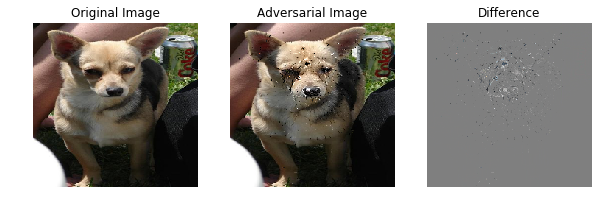

In [ ]:
from PIL import Image, ImageOps
import cv2
import matplotlib.pyplot as plt
#########################################
##此处的pname可替换为你想查看的图片
pname = "n02085620_10074.jpg"
#########################################
image_name, image_ext = pname.split('.')
pname_attack = image_name + ".png"
original_img=np.array(Image.open("/home/aistudio/baidu_attack_by_xin/input_image/" + pname))
adversarial_img=np.array(Image.open("/home/aistudio/baidu_attack_by_xin/output_image_attack/" + pname_attack))
show_images_diff(original_img,adversarial_img)

### 此方案生成的对抗样本具有良好的迁移能力，可以在AI安全对抗赛中取得第二名，以此标准

![](https://ai-studio-static-online.cdn.bcebos.com/a65f6e2ca1cb4647ac642f9b1a5f0e5466f94fa552a141ee9f8fe49bcda3d233)

其中M表示防御模型，y表示样本I的真实标签。如果防御算法对样本识别正确，此次攻击不成功，扰动量直接置为上限128。如果攻击成功，计算对抗样本和原始样本的扰动量，采用平均L2距离。每个对抗样本都会在m个防御模型上计算扰动量，n代表样本个数，最后对所有的扰动量进行平均，做为本次攻击的整体距离得分，得分越小越好。

### 为衡量标准，我方案生成的图片可以达到3.78089。

### 4 临门一脚

然而这不够，作为一个竞赛，人人都虎视眈眈盯着奖金的时候，还需要不断的提升。因此还需要**临门一脚**，一种后处理方法。

### 小扰动截断
使用上述方法后，我的结果在95-96分之间波动，为进一步提升成绩，我选用最高分96.53分图片进行后处理。后处理方法为：**将攻击后的图片与原图片进行对比，对一定阈值以下的扰动进行截断。** 经过不断上探阈值，发现阈值为17(图片的像素范围为0-255)的时候效果最好。此方法提分0.3左右。

代码如下：

**提前预警：** 运行下面代码需要生成全部对抗样本。

In [ ]:
#coding=utf-8

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import functools
import numpy as np
import paddle.fluid as fluid

#加载自定义文件
import models
from attack.attack_pp import FGSM, PGD
from utils import *

######Init args
image_shape = [3,224,224]
class_dim=121
input_dir = "./input_image/"
attacked_dir = "./output_image_attack/"
output_dir = "./posopt_output_image/"
drop_thres = 10
os.makedirs("./posopt_output_image") 
val_list = 'val_list.txt'
use_gpu=True


####### Main #######
def get_original_file(filepath):
    with open(filepath, 'r') as cfile:
        full_lines = [line.strip() for line in cfile]
    cfile.close()
    original_files = []
    for line in full_lines:
        label, file_name = line.split()
        original_files.append([file_name, int(label)])
    return original_files

def gen_diff():
    original_files = get_original_file(input_dir + val_list)

    for filename, label in original_files:
        image_name, image_ext = filename.split('.')
        img_path = input_dir + filename
        print("Image: {0} ".format(img_path))
        img=process_img(img_path)
        adv_img_path = attacked_dir + image_name+'.png'
        adv=process_img(adv_img_path)
        
        org_img = tensor2img(img)
        adv_img = tensor2img(adv)
        #10/256 以下的扰动全部截断
        diff = abs(org_img-adv_img)<drop_thres   #<10的为1
        diff_max = abs(org_img-adv_img)>=drop_thres  #>=10的为1
        #<10的保留org_img
        tmp1 = np.multiply(org_img,diff)
        #>10的保留adv_img
        tmp2 = np.multiply(adv_img,diff_max)
        final_img = tmp1+tmp2
        
        save_adv_image(final_img, output_dir+image_name+'.png')


gen_diff()


### 写在赛后 
1. 以上就是本人在AI安全对抗赛取得第二名的全部方案，如需在终端执行，下面介绍了终端执行说明，感谢阅读。
2. 决赛赛程中我霸榜半个月有余，绞尽脑汁尝试各种攻击方法，不断阅读论文，不断尝试效果。我很享受这种过程，照猫画虎快速入门了paddle，成长了很多。
3. 然而最后半个小时还是被反超。赛后交流发现他们序列攻击了十几个模型，然而我集成了9个模型就停止了。也许霸榜让我有了一丝松懈。
4. 致读者，这是一个非常好的入门对抗样本的机会，细嚼baseline和我的方案将让你入门4-5种这个领域的算法。
5. 感谢AI studio让我用到了v100，我自己的台式机装的1050可是连n年前的vgg都跑不动。

### 参考文献

[1] Liu Y , Chen X , Liu C , et al. Delving into Transferable Adversarial Examples and Black-box Attacks[J]. 2016.

[2] Shi Y , Wang S , Han Y . Curls & Whey: Boosting Black-Box Adversarial Attacks[J]. 2019.

[3] Narodytska N , Kasiviswanathan S P . Simple Black-Box Adversarial Perturbations for Deep Networks[J]. 2016.

[4] Huang Q , Katsman I , He H , et al. Enhancing Adversarial Example Transferability with an Intermediate Level Attack[J]. 2019.

[5] https://www.cs.cmu.edu/~sbhagava/papers/face-rec-ccs16.pdf

[6] Understanding and Enhancing the Transferability of Adversarial Examples


## 代码使用说明

依赖库：
- python3
- paddle
- numpy



使用步骤:
* 在终端输入
* cd baidu_attack_by_xin/
* python 9model_ensemble_attack.py
* python pert_drop.py
* 结果保存在posopt_output_image
